In [1]:
from itertools import combinations

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from unidecode import unidecode
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from feature_engine import categorical_encoders as ce

from itertools import combinations
from datetime import datetime
from contextlib import contextmanager

In [2]:
NUM_BOOST_ROUND= 10000
"""
DROP = ["gioiTinh","info_social_sex", 'currentLocationCity', 'currentLocationName', 'homeTownCity', 'homeTownName'] + \
[f"Field_{c}" for c in [11, 14, 15, 16, 17, 18, 24,25, 26, 30, 31, 32, 33, 34,35, 37,40,45, 46, 48,49, 52, 56, 57, 68]]
DATE = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 34, 35, 40]]
"""

'\nDROP = ["gioiTinh","info_social_sex", \'currentLocationCity\', \'currentLocationName\', \'homeTownCity\', \'homeTownName\'] + [f"Field_{c}" for c in [11, 14, 15, 16, 17, 18, 24,25, 26, 30, 31, 32, 33, 34,35, 37,40,45, 46, 48,49, 52, 56, 57, 68]]\nDATE = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 34, 35, 40]]\n'

In [3]:
DATE = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 34, 35, 40]]
DATETIME = ["Field_{}".format(i) for i in [1, 2, 43, 44]]

In [4]:
CATEGORICAL = ["brief"]+["Field_{}".format(i) for i in [3, 4, 10, 13, 14, 16, 17, 21, 22, 24, 26, 27, 28, 29, 30, 31, \
                                          37, 38, 39, 41, 42, 47, 50, 51, 52, 58, 61, 62,65]]

In [5]:
DROP = ["diaChi","namSinh", "gioiTinh", 'currentLocationCity', "currentLocationCountry", 'currentLocationName',\
        'homeTownCity',"homeTownCountry", 'homeTownName']\
+ ["Field_{}".format(i) for i in [18, 45, 46, 48, 49, 56]]

In [6]:
NUMERICAL = ["Field_{}".format(i) for i in [18, 19, 20, 23, 59, 60, 63, 64, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77,\
                                           78, 79, 80, 81, 82]] + ["friendCount", "info_social_sex", "topFriends", "numOrg", \
                                           "F_numOrg", "E_numOrg", "E_numQuery", "C_numOrg", "C_numQuery", \
                                           "G_numOrg", "G_numQuery", "A_numOrg", "A_numQuery","summary_6m", \
                                           "summary_3m", "summary_1m", "summary_1w", "num_of_phone"]


In [7]:
def subtract_date(date1,date2, df):
    df[date1] = pd.to_datetime(df[date1], infer_datetime_format=True)
    df[date2] = pd.to_datetime(df[date2], infer_datetime_format=True)
    df[date1+date2] = (df[date2] - df[date1]).dt.days
def process_ngaySinh(s):
    if s != s:
        return np.nan
    try:
        s = int(s)
    except ValueError:
        s = s.split(" ")[0]
        
    return datetime.strptime(str(s)[:6], "%Y%m")
def datetime_normalize(s):
    if s != s:
        return np.nan
    
    s = s.split(".")[0]
    if s[-1] == "Z":
        s = s[:-1]
        
    date, time = s.split("T")
    datetime_obj = datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj
def date_normalize(s):
    if s != s:
        return np.nan
    
    try:
        datetime_obj = datetime.strptime(s, "%m/%d/%Y")
    except:
        datetime_obj = datetime.strptime(s, "%Y-%m-%d")
        
    return datetime_obj
def process_datetime_cols(df):
    cat_cols = []
    for col in DATETIME:
        df[col] = df[col].apply(datetime_normalize)
        
    for col in DATE:
        if col == "Field_34":
            continue
        df[col] = df[col].apply(date_normalize)

    df["Field_34"] = df["Field_34"].apply(process_ngaySinh)
    df["ngaySinh"] = df["ngaySinh"].apply(process_ngaySinh)
    
    cat_cols += DATE + DATETIME
    for col in DATE + DATETIME:
        df[col] = df[col].dt.strftime('%d-%m-%Y')
    
    subtract_date('Field_5','Field_6',df)
    subtrac_List = ['Field_1', 'Field_2', 'Field_43', 'Field_44', 'Field_7','Field_8', 'Field_9']
    subtract_2C = list(combinations(subtrac_List, 2))
    for l in subtract_2C:
        subtract_date(l[0],l[1],df)
    
    for cat in ['F', 'E', 'C', 'G', 'A']:
        subtract_date(f'{cat}_startDate', f'{cat}_endDate', df)
    print(df.shape) 
    return df
def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s
def process_location(df):
    for col in ["currentLocationLocationId", "homeTownLocationId", "currentLocationLatitude", "currentLocationLongitude", 
                   "homeTownLatitude", "homeTownLongitude"]:
        df[col].replace(0, np.nan, inplace=True)
    return df
def combine_gender(s):
    x, y = s
    return x if x is not np.nan else y if y is np.nan else np.nan
def process_gender(df):
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1)
    return df
def process_ordinal(df):        
    df["subscriberCount"].replace(0, np.nan, inplace=True)
    df["friendCount"].replace(0, np.nan, inplace=True)
    
    df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
    df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4}) 

            
    return df

def fix_maCv(x):
    lower = str(x).lower()
    if any([x in lower for x in ["nhân viên", "kế toán", "thủ kho", "tạp vụ",\
                                "thu ngân", "phóng viên", "giao dịch", "operator", "cnv",\
                                "huấn luyện viên", "ktoán", "nv", "lễ tân", "thư ký ",\
                                "gsbh", "tiếp viên", "nhõn viờn", "chăm sóc", "hướng dẫn viên", \
                                "kiểm phẩm",  "kĩ sư",  "cấp dưỡng", "kiểm gấp",\
                                "kiểm soát viên", "kiểm ngân", "nv", "lưu hóa", "nhân  viên", "lưu trữ viên", \
                                "phát hành báo", "ktv", "kiến trúc sư", "kinh tế viên", "staff", "checker",\
                                "sỹ quan", "dịch vụ", "kiểm tra viên", \
                                "cộng tác viên", "qc ksqt", "nhân vên", "kế hoạch sản xuất", "nhaõn vieõn", \
                                "thí nghiệm", "thông kê", "kiểm hàng", "k? s?", "thư ký", "hợp đồng", \
                                "thẩm phán", "thao tác viên", "thủ quỹ", "lấy mẫu", "LÁI XE".lower(), \
                                "biên tập", "ksxd", "phiên dịch", "tb tuyên huấn", "sales", "thường trực", \
                                "trợ lý", "tiếp thực", "giỏm sỏt", \
                                "trình dược viên", "btđtn", "phúng viờn", \
                                "thông dịch", "tiếp thị", "tư vấn", "tổng đài", "vi tính", "viên chức", \
                                "văn phòng", "văn thư", 'Thiết Kế'.lower(), "vận hành", "nhan vien", \
                                "kiểm tra chất lượng", "pbt", "phi công", "laptop",\
                                "phụ trách kiểm hàng", "quay phim", "thư viện viên", \
                                "trực buồng", "techcombank", "cảng vụ viên", "trainee", "bhxh", "marketing", \
                                "tuyên truyền viên",  "kế hoạch", "ks", \
                                "an toàn viên", "CHỈ SỐ VIÊN".lower(), \
                                "thu mua", "giám éịnh viên", "kiểm định viên",  "giám định", \
                                "quản trị mạng", "thơợ", "thống kê", "thủ  quỹ",  \
                                "điện thoại", "điện thọai", "đội thông tin", "đón  tiếp khách hàng", \
                                "đơn hàng", "đại diện", "điều phối viên", "n.v", "bán vé", "c«ng nh©n", \
                                "gs camera",  "máy dán", "tv",  "đồ họa"]]):
        return "NV"
    elif any([x in lower for x in ["kỹ","chuyên viên","kĩ thuật viên","kĩ thuật", "kỹ thuật viên",\
                                 "kỷ thuật viên","lập trình viên", "chuyờn viờn", "chuyªn viªn",]]):
        return "KTV"
    elif any([x in lower for x in ["cán bộ", "cán sự", "bí thư đoàn", "cb", "phường đội", "trưởng công an", \
                                  "công an viên", "an ninh viên","tổ viên", "công chức", "quản sinh", \
                                   "bí thư xã  đoàn","điều tra viên", "đăng kiểm", "cỏn bộ","đtv", "trực ban",\
                                  ]]):
        return "CB"
    elif any([x in lower for x in ["tổ trưởng", "giám sát", "quản lý", "cửa hàng trưởng", "chuyền trưởng", "kho",\
                                  "phó", "pp", "nhóm trưởng", "trưởng phòng", "trưởng ca", "trưởng tàu khách", \
                                  "trưởng nhóm", "cửa hàng trưởng", "trưởng bộ", "tổng phụ trách", "đào tạo", \
                                  "phụ trách phòng", "quản doanh", "vhtt", "trưởng ban", "dự án", "nhân sự",\
                                  "chỉ huy", "triển khai", "trưởng kiểm soát", "điều hành", "đội trưởng", \
                                  "chỉ huy", "qlsx", "t? tr??ng", "may"]]):
        return "QL"
    elif any([x in lower for x in ["công",  "bảo vệ", "thợ", "lao động", "bán hàng",\
                                "phụ kho", "phụ việc", "phết", "bảo mẫu", "phục vụ", "đóng gói", "ép cao tần", \
                                "cn", "sản Phẩm", "giao nhận","cụng nhõn", "gia công", "kiÓm tra".lower(), \
                                "cô nuôi", "bảo dưỡng", "c.n", "coi bồn", "cạo mủ", "coõng nhaõn", "khai thác",\
                                "cod", "bốc xếp", "bếp", "lái máy", "lđpt", "khuôn", "hàng rong", "phụ bếp",\
                                "phụ tá", "thủ công", "dệt", "sửa chữa", "băng chuyền", "lắp ráp", \
                                "chà nhám", "cn", "bếp phụ", "chụp hình", "KHUNG SắT".lower(), "kcs chuyền", \
                                "lao động", "thành hình", "lao công", "cônh nhân", "thi công", "cán lần 1", \
                                "lái phụ máy", "thủy thủ", "gác ghi", "quay ghi", "bảo trì", "bảo mẩu", \
                                "máy 3 tàu", "giao hàng", "trực chính", "hỗ trợ", "lái xúc gạt", "công  nhân",\
                                "lđhđ", "lao d?ng", "c. nhân", "pv nước", "hđlđ", "vệ sinh", "phụ", "vệ sỹ", \
                                "xếp hộp", "barista", "hàn điện", "thuỷ thủ", "xây dựng", "b?o v?", \
                                "mài phá", "xếp da", "worker", "cong nhan", "pha chế", \
                                "máy trưởng", "phụ trách sản xuất", "trải vải", "YếN TIệC".lower(), "gấp xếp", \
                                "in sơ đồ", "lđ phổ thông", "mài", "nhồi mút", "ép", "gói", "đóng", \
                                "đội viên", "đánh máy", "đứng máy", "ủi", "săm", 'atlđ']]):
        return "CN"
    elif any([x in lower for x in ["lái xe", "tài xế", "phụ xe","lái cẩu", "vân hành", ]]):
        return "TX"
    elif any([x in lower for x in ["giáo viên", "gv", "giảng viên", "chủ nhiệm lớp", "giáo viến", \
                                   "Giáo viến".lower(), "mầm non"]]):
        return "GV"
    elif any([x in lower for x in ["kinh doanh", "kinh  doanh"]]):
        return "KD"

    elif any([x in lower for x in ["hiệu trưởng", "chủ tịch", "pgđ", "giám đốc"]]):
        return "GĐ"
    elif any([x in lower for x in ["điều dưỡng", "hộ lý", "nữ hộ sinh", "h? lý", "hộ sinh"]]):
        return "ĐD"
    elif any([x in lower for x in ["y sĩ", "dược sỹ", "bác sĩ", "bác sỹ", "dược", "dược tá", "thú y", "y sỹ",\
                                  "y tế", "y công", "y tá", "dựơc tá", "ytth"]]):
        return "BS"
    elif any([x in lower for x in ["cử nhân", "cđ", "học viên", "tc", "cao đẳng", "cao đẵng", "trung cấp"]]):
        return "HS"
    elif any([x in lower for x in ["diễn viên", "ca sĩ"]]):
        return "DV-CS"
    elif any([x in lower for x in ["undefined", "nguyễn thế hưng", "ln091", "thieu chuc danh", "th noọng hẹt", \
                                  "875 lk", "-", "p.xnk", "cỏn b?", '22568', "unt", "01019882", "xtnt", "ltv", \
                                  "plđg hc", "mia", "pqtd", "kttntl", "llqs", "kcsmhm", "nt", "dtm", "i", "qc",\
                                  '/  /', '1', '14', 'a', 'chủ hộ', 'coõng vuù', 'kcs', 'pk b2c',\
                                   'xt2', 'kcs', 'sxct']]):
        return np.nan
    return x
def check(x,y):
    if x is np.nan or y is np.nan:
        return "Missing_4849"
    elif x == y:
        return "Yes"
    else:
        return "No"
def fix_4849(df):
    df["fix4849"] = df.Field_48
    for i in range(len(df)):
        df["fix4849"].iloc[i] = check(df.Field_48.iloc[i],df.Field_49.iloc[i])
    return df
def fix_location(df):
    df["location"] = df.Field_48
    for i in range(len(df)):
        df["location"].iloc[i] = check(df.homeTownState.iloc[i],df.currentLocationState.iloc[i])
    return df
def fix_currentLocationState(x):
    if x in ['Ilhas', 'Daegu', 'Auckland Region', 'Basse-Normandie', 'Chongqing', "Provence-Alpes-Côte d'Azur",\
             'Rajshahi Division', 'Hubei', 'Mandalay', 'Missouri', 'Pathum Thani', 'Central Java', 'New Hampshire',\
             'Odisha', 'South Australia', 'Chon Buri', 'Haute-Normandie', 'Kirov Oblast', 'Primorsky Krai', 'Arizona',\
             'Ulsan', 'Kanagawa Prefecture', 'Metro Manila', 'Kachin State', 'Svay Rieng Province', 'Nagano Prefecture',\
             'Shiga Prefecture', 'Oslo', 'Indiana', 'Hunan', 'Bolikhamsai Province', 'Krasnoyarsk Krai',\
             'Distrito Nacional', 'Chiba Prefecture', "Seoul", "New York", "Sarawak", "Sarawak", "England", \
            "California", "Singapore", "Guangdong", "Osaka Prefecture", "Tokyo", "Taipei", "Busan", "Île-de-France",
            "Île-de-France","Dubai", "Ohio", "Florida", "Texas", "Shanghai", "Nevada", "Victoria", "Vientiane Prefecture",\
            "Hong Kong", "Nagasaki Prefecture", "Jeju-do", "Bangkok", "Aichi Prefecture", "Taraba State", "Akershus", \
            "Gyeongsangnam-do", "Washington, District of Columbia", "Cataluña", "Hsinchu City", "Saitama Prefecture",\
            "Ibaraki Prefecture", "Hyōgo Prefecture", "New South Wales", "Abu Dhabi", "Dhaka Division", "Brazzaville",\
            'Busan', 'Cataluña', 'Dhaka Division', 'Dubai', 'Edo State', 'Florida', 'Fukuoka Prefecture', 'Guangxi', \
             'Gyeongsangnam-do', 'Hokkaido', 'Hong Kong', 'Hsinchu City', 'Hyōgo Prefecture', 'Ibaraki Prefecture', \
             'Illinois', 'Jeju-do', 'Massachusetts', 'Michigan', 'Nagasaki Prefecture', 'Nevada', \
             'New South Wales', 'Ohio', 'Saitama Prefecture', 'Shanghai', 'Taichung', 'Taipei', 'Taraba State',\
             'Texas', 'Tokyo', 'Victoria', 'Vientiane Prefecture', 'Washington, District of Columbia', 'Western Australia',\
             'Île-de-France', 'Ailinglaplap Atoll', 'Alabama', 'Antioquia', 'Attapeu Province', 'Bandundu', 'Bashkortostan', \
             'Benguela Province', 'Bicol Region', 'Buenos Aires', 'Central Kalimantan', 'Changhua', 'Chin State',\
             'Chungcheongbuk-do', 'Corse', 'Daejeon', 'Doukkala-Abda', 'Emilia-Romagna', 'Equatoria', 'Fujian', \
             'Fukui Prefecture', 'Gangwon-do', 'Georgia', 'Gifu Prefecture', 'Guatemala Department', 'Guizhou',\
             'Gunma Prefecture', 'Gwangju', 'Gyeonggi-do', 'Havana', 'Hela Province', 'Hiroshima Prefecture', \
             'Idaho', 'Ilocos Region', 'Incheon', 'Istanbul Province', 'Jakarta', 'Jeollanam-do', 'Kampong Cham Province',\
             'Kaohsiung', 'Kharkiv Oblast', 'Khon Kaen', 'Khuzestan Province', 'Kuala Lumpur', 'Kumamoto Prefecture',\
             'Kyustendil Province', 'La Rioja', 'Lagos State', 'Lombardia', 'Louisiana', 'Madhya Pradesh', 'Manitoba',\
             'Martinique', 'Masovian Voivodeship', 'Miaoli', 'Mie Prefecture', 'Miyazaki Prefecture', 'Moscow',\
             'New Providence', 'New Taipei City', 'Niedersachsen', 'Nordrhein-Westfalen', 'North Carolina', \
             'Okayama Prefecture', 'Okinawa Prefecture', 'Ontario', 'Orientale', 'Pennsylvania', 'Phnom Penh', \
             'Pingtung', 'Prague', 'Queensland', 'Ras al-Khaimah', 'Sakon Nakhon', 'Scotland', 'Shaanxi', 'Shandong', \
             'Sichuan', 'South Eastern Region', 'Suphan Buri', 'Surin', 'Taoyuan City', 'Tbong Khmum Province', \
             'Toyama Prefecture', 'Utah', 'Uttar Pradesh', 'Uíge Province', 'Veneto', 'Vientiane Province', 'Washington',\
             'Western Visayas', 'Yamaguchi Prefecture']:
        return "oversea"
    return x
def fix_homeTownState(x):
    if x in ['Ilhas', 'Daegu', 'Auckland Region', 'Basse-Normandie', 'Chongqing', "Provence-Alpes-Côte d'Azur",\
             'Rajshahi Division', 'Hubei', 'Mandalay', 'Missouri', 'Pathum Thani', 'Central Java', 'New Hampshire',\
             'Odisha', 'South Australia', 'Chon Buri', 'Haute-Normandie', 'Kirov Oblast', 'Primorsky Krai', 'Arizona',\
             'Ulsan', 'Kanagawa Prefecture', 'Metro Manila', 'Kachin State', 'Svay Rieng Province', 'Nagano Prefecture',\
             'Shiga Prefecture', 'Oslo', 'Indiana', 'Hunan', 'Bolikhamsai Province', 'Krasnoyarsk Krai',\
             'Distrito Nacional', 'Chiba Prefecture', "Seoul", "New York", "Sarawak", "Sarawak", "England", \
            "California", "Singapore", "Guangdong", "Osaka Prefecture", "Tokyo", "Taipei", "Busan", "Île-de-France",
            "Île-de-France","Dubai", "Ohio", "Florida", "Texas", "Shanghai", "Nevada", "Victoria", "Vientiane Prefecture",\
            "Hong Kong", "Nagasaki Prefecture", "Jeju-do", "Bangkok", "Aichi Prefecture", "Taraba State", "Akershus", \
            "Gyeongsangnam-do", "Washington, District of Columbia", "Cataluña", "Hsinchu City", "Saitama Prefecture",\
            "Ibaraki Prefecture", "Hyōgo Prefecture", "New South Wales", "Abu Dhabi", "Dhaka Division", "Brazzaville",\
            'Busan', 'Cataluña', 'Dhaka Division', 'Dubai', 'Edo State', 'Florida', 'Fukuoka Prefecture', 'Guangxi', \
             'Gyeongsangnam-do', 'Hokkaido', 'Hong Kong', 'Hsinchu City', 'Hyōgo Prefecture', 'Ibaraki Prefecture', \
             'Illinois', 'Jeju-do', 'Massachusetts', 'Michigan', 'Nagasaki Prefecture', 'Nevada', \
             'New South Wales', 'Ohio', 'Saitama Prefecture', 'Shanghai', 'Taichung', 'Taipei', 'Taraba State',\
             'Texas', 'Tokyo', 'Victoria', 'Vientiane Prefecture', 'Washington, District of Columbia', 'Western Australia',\
             'Île-de-France', 'Ailinglaplap Atoll', 'Alabama', 'Antioquia', 'Attapeu Province', 'Bandundu', 'Bashkortostan', \
             'Benguela Province', 'Bicol Region', 'Buenos Aires', 'Central Kalimantan', 'Changhua', 'Chin State',\
             'Chungcheongbuk-do', 'Corse', 'Daejeon', 'Doukkala-Abda', 'Emilia-Romagna', 'Equatoria', 'Fujian', \
             'Fukui Prefecture', 'Gangwon-do', 'Georgia', 'Gifu Prefecture', 'Guatemala Department', 'Guizhou',\
             'Gunma Prefecture', 'Gwangju', 'Gyeonggi-do', 'Havana', 'Hela Province', 'Hiroshima Prefecture', \
             'Idaho', 'Ilocos Region', 'Incheon', 'Istanbul Province', 'Jakarta', 'Jeollanam-do', 'Kampong Cham Province',\
             'Kaohsiung', 'Kharkiv Oblast', 'Khon Kaen', 'Khuzestan Province', 'Kuala Lumpur', 'Kumamoto Prefecture',\
             'Kyustendil Province', 'La Rioja', 'Lagos State', 'Lombardia', 'Louisiana', 'Madhya Pradesh', 'Manitoba',\
             'Martinique', 'Masovian Voivodeship', 'Miaoli', 'Mie Prefecture', 'Miyazaki Prefecture', 'Moscow',\
             'New Providence', 'New Taipei City', 'Niedersachsen', 'Nordrhein-Westfalen', 'North Carolina', \
             'Okayama Prefecture', 'Okinawa Prefecture', 'Ontario', 'Orientale', 'Pennsylvania', 'Phnom Penh', \
             'Pingtung', 'Prague', 'Queensland', 'Ras al-Khaimah', 'Sakon Nakhon', 'Scotland', 'Shaanxi', 'Shandong', \
             'Sichuan', 'South Eastern Region', 'Suphan Buri', 'Surin', 'Taoyuan City', 'Tbong Khmum Province', \
             'Toyama Prefecture', 'Utah', 'Uttar Pradesh', 'Uíge Province', 'Veneto', 'Vientiane Province', 'Washington',\
             'Western Visayas', 'Yamaguchi Prefecture']:
        return "oversea"
    return x
def fix_54(x):
    if x == "1" or x == "01" or x == ' P. Tân Phú':
        return "VN"
    elif x in ['IT', 'GB', 'SE', 'TK', 'BD']:
        return np.nan
    return x
    return x
def fix_55(x):
    if x in ['BC', 'BG', 'CN', 'CO', 'DB', 'EL', 'FO', 'H5', 'KX', 'N7', 'NR', 'SD', 'SJ', 'ST', 'WD']:
        return np.nan
    return x
def fix_68(x):
    if x is np.nan:
        return "Missing_68"
    else:
        return "Yes"
def fixdata_basic_info_locale(x):
    if x == "_VN":
        return 'vi_VN'
    elif x in ['lv_LV', 'ru_RU']:
        return np.nan
    return x
def transform(df):
    df = process_datetime_cols(df)
    df = process_gender(df)
    df = process_location(df)
    df = process_ordinal(df)
    return df.drop(DROP, 1)
def check_duplicate(feature1, feature2):
    check1 = list(df_train[feature1].fillna("NaN"))
    check2 = list(df_train[feature2].fillna("NaN"))
    return check1 == check2

In [8]:
df_train = pd.read_csv("../../data/kalapa/train.csv")
df_test = pd.read_csv("../../data/kalapa/test.csv")
df_all = df_train.drop(['label'], 1).append(df_test)

df_all.maCv = df_all.maCv.apply(fix_maCv)
df_all = fix_4849(df_all)
df_all = fix_location(df_all)
df_all.currentLocationState = df_all.currentLocationState.apply(fix_currentLocationState)
df_all.homeTownState = df_all.homeTownState.apply(fix_homeTownState)
df_all.Field_54 = df_all.Field_54.apply(fix_54)
df_all.Field_55 = df_all.Field_55.apply(fix_55)
df_all.Field_68 = df_all.Field_68.apply(fix_68)
df_all["data.basic_info.locale"] = df_all["data.basic_info.locale"].apply(fixdata_basic_info_locale)

df_all_fe = transform(df_all.copy())
df_all_fe['Age'] = df_all_fe.ngaySinh.apply(lambda x: 2020 - x.year)
df_all_fe = df_all_fe.drop('ngaySinh', axis = 1)
cols_select = [x for x in df_all_fe.columns if x not in DATE + DATETIME  + [f'{cat}_endDate' for cat in ['F', 'E', 'C', 'G', 'A']] + [f'{cat}_startDate' for cat in ['F', 'E', 'C', 'G', 'A']]]
df_fe = df_all_fe[cols_select]

for col in df_fe.columns:
    vc = df_fe[col].value_counts()
    if len(vc) <= 3 or col in CATEGORICAL or df_fe[col].dtype.name == "object":
        df_fe[col] = df_fe[col].fillna("Missing_" + col).astype("category")
    elif col in NUMERICAL or df_fe[col].dtype.name == "float64" or df_fe[col].dtype.name == "int64":
        df_fe[col] = df_fe[col].fillna(df_fe[col].iloc[:len(df_train)].mean())
distinct_columns = {}

for col1 in df_fe.columns:
    vc = df_fe[col1].value_counts()
    index = [len(vc), set(list(vc)), set(list(vc.index))]
    for col2 in distinct_columns:
        if index == distinct_columns[col2] and check_duplicate(col1, col2):
            break
    else:
        distinct_columns[col1] = index
df_fe = df_fe[distinct_columns]
y_label = df_train["label"]
train_fe = df_fe[df_fe["id"] < df_train.shape[0]]
test_fe = df_fe[df_fe["id"] >= df_train.shape[0]]


# Label-Encoding
lbl = LabelEncoder()
for col in df_fe.columns:
    if df_fe[col].dtype.name == "category":
        train_fe[col] = train_fe[col].astype(str)
        test_fe[col] = test_fe[col].astype(str)
        encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency')
        train_fe[col] = train_fe[col].fillna('None')
        test_fe[col] = test_fe[col].fillna('None')

        # Only take the common values in Train/Test set
        common_vals = list(set(train_fe[col]).intersection(set(test_fe[col])))

        # Take if vals appeared both 5 times
        #common_vals = set(train_fe[col].value_counts()[train_fe[col].value_counts() > 10].index).intersection(test_fe[col].value_counts()[test_fe[col].value_counts()>4].index)

        # Replace not-common values with "Missing" or np.nan
        train_fe.loc[~train_fe[col].isin(common_vals), col] = 'Missing'
        test_fe.loc[~test_fe[col].isin(common_vals), col] = 'Missing'

        # Implement LE
        lbl.fit(train_fe[col].tolist() + test_fe[col].tolist())
        train_fe[col] = lbl.transform(train_fe[col])
        test_fe[col] = lbl.transform(test_fe[col])


print(train_fe.shape)
print(test_fe.shape)

/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(73411, 223)
id
Field_3
Field_4
Field_10
Field_12
Field_13
Field_14
Field_16


/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Field_17
Field_19
Field_20
Field_21
Field_22
Field_23
Field_24
Field_26
Field_27
Field_28
Field_29
Field_30
Field_31
Field_36
Field_37
Field_38
Field_39
Field_41
Field_42
Field_47
Field_50
Field_51
Field_52
Field_53
Field_54
Field_55
Field_57
Field_58
Field_59
Field_60
Field_61
Field_62
Field_63
Field_64
Field_65
Field_66
Field_67
Field_68
maCv
Field_69
Field_70
Field_71
Field_72
Field_73
Field_74
Field_75
Field_76
Field_77
friendCount
info_social_sex
subscriberCount
currentLocationLocationId
currentLocationLatitude
currentLocationLongitude
homeTownLocationId
homeTownLatitude
homeTownLongitude
data.basic_info.locale
currentLocationState
homeTownState
topFriends
numOrg
F_numOrg
F_numQuery
E_numOrg
E_numQuery
C_numOrg
C_numQuery
G_numOrg
G_numQuery
A_numOrg
A_numQuery
summary_6m
summary_3m
summary_1m
summary_1w
partner0_A
partner0_B
partner0_C
partner0_D
partner0_E
partner0_F
partner0_G
partner0_H
partner0_K
partner0_L
partner1_A
partner1_B
partner1_C
partner1_D
partner1_E
partner1_F
par

/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

(53030, 182)
(20381, 182)


In [10]:
train_fe

,id,Field_3,Field_4,Field_10,Field_12,Field_13,Field_14,Field_16,Field_17,Field_19,...,Field_7Field_8,Field_7Field_9,Field_8Field_9,F_startDateF_endDate,E_startDateE_endDate,C_startDateC_endDate,G_startDateG_endDate,A_startDateA_endDate,gender,Age
0,0,0,0,0,4,0,0,0,0,0.000000,...,211.00000,-5.000000,-216.000000,11.499164,12.691521,7.262557,3.574689,67.000000,1,29.000000
1,1,2,1,6,7,1,1,1,1,0.267022,...,334.93749,57.609764,-277.327726,11.499164,12.691521,7.262557,3.574689,0.000000,2,31.657761
2,2,1,2,0,7,0,0,0,0,0.000000,...,364.00000,16.000000,-348.000000,0.000000,24.000000,7.262557,3.574689,47.000000,0,22.000000
3,3,2,1,6,7,1,1,1,1,0.267022,...,334.93749,57.609764,-277.327726,11.499164,12.691521,7.262557,3.574689,50.106553,2,31.657761
4,4,2,1,6,7,1,1,1,1,0.267022,...,334.93749,57.609764,-277.327726,11.499164,12.691521,7.262557,3.574689,50.106553,2,31.657761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53025,53025,0,0,0,7,0,0,0,0,1.000000,...,365.00000,-8.000000,-373.000000,0.000000,0.000000,0.000000,3.574689,202.000000,0,32.000000
53026,53026,2,1,6,7,1,1,1,1,0.267022,...,334.93749,57.609764,-277.327726,11.499164,12.691521,7.262557,0.000000,52.000000,2,31.657761
53027,53027,1,2,0,4,0,0,0,0,0.000000,...,327.00000,196.000000,-131.000000,11.499164,12.691521,7.262557,3.574689,50.106553,0,32.000000
53028,53028,2,1,6,7,1,1,1,1,0.267022,...,334.93749,57.609764,-277.327726,11.499164,12.691521,7.262557,3.574689,0.000000,2,31.657761


In [11]:
from sklearn.preprocessing import scale
Xnorm = scale(train_fe.iloc[:,1:])
testnorm = scale(test_fe.iloc[:,1:])

/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=181)
pca.fit(Xnorm)

PCA(n_components=181)

90.15628999999997


Text(0, 0.5, 'Variance captured')

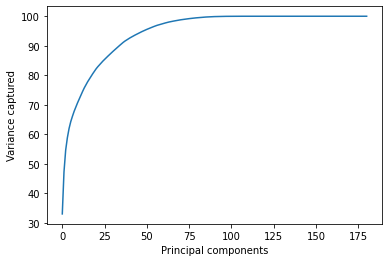

In [13]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=7)*100)
print(var1[34])
plt.plot(var1)
plt.xlabel("Principal components")
plt.ylabel("Variance captured")

In [14]:
pca = PCA(n_components=34)
pca.fit(Xnorm)

PCA(n_components=34)

In [15]:
X = pca.transform(Xnorm)
test = pca.transform(testnorm)

In [16]:
train_fe = pd.DataFrame(X)
test_fe = pd.DataFrame(test)

In [17]:
df_train = pd.concat([df_train.id,df_train.label, train_fe], axis = 1)
test_fe = pd.concat([df_test.id, test_fe], axis = 1)

In [18]:
data_version = "07-01-2021-v1"

In [19]:
os.makedirs(f"../../data/kalapa/{data_version}/", exist_ok=True)
df_train.to_csv(f"../../data/kalapa/{data_version}/train.csv", index = False)
test_fe.to_csv(f"../../data/kalapa/{data_version}/test.csv", index = False)